This script will
- Get data from stations
- Get processed altimeter data
- Plot data location
- Plot time series altimeter and station
- Calculate and Plot accuracies
- Separate low level from high levels

In [1]:
from ground_data import GroundObservations
from ts_preprocesing import *#get_date_time_cols
import scipy.interpolate as sc
import geopandas as gpd
from timezonefinder import TimezoneFinder
# from ts_preprocesing import convert_units
import importlib
import pandas as pd
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pytz
from pytz import timezone
import timeit
from datetime import datetime
utc=pytz.utc
utc.zone
%load_ext autoreload
%autoreload 2

In [39]:
#Test Getting data from stations
#So far what works
# Getting locss stations
# Getting ARHN stations 
# Getting USGS stations from file. Still working on R script connection
go=GroundObservations()
height_fd='height'

lc_lakes=['KHB2','HMT2','PHN2','SAW2','RAW2','BTN2','QUL2', 'WEW2', 'CFN2','YSL2','SLL2','TAB2','MAB2', 'CQK2', 'SKT2', 'MCW2', 'PAW2', 'MRP2']
# lc_lakes=['CQK2']
df_locss=go.read_ground_data('LOCSS', station_id=lc_lakes)
df_locss=get_date_time_cols(df_locss, 'date', has_hour=True)
stations=df_locss['gauge_id'].unique()
df_final=convert_units(df_locss,height_fd, origin='FEET', to='METER', unit_fd='unit',
                  gauge_fd='gauge_id')


# #'2102' Is a meteorlogical station 

# ar_lakes=['1805', '1819', '1824', '2830', '1830','2832', '2028','2231','2234','2300','2316']
# skip_rows=1

# df_arhn=go.read_ground_data('ARHN', skip_rows=skip_rows, station_id=ar_lakes)
# df_arhn=get_date_time_cols(df_arhn, 'date', has_hour=True)

us_lakes=['2464800','6903880','6604000']
df_usgs=go.read_ground_data('USGS',station_id=us_lakes)
df_usgs=get_date_time_cols(df_usgs, 'date')
df_usgs=convert_units(df_usgs,height_fd, origin='FEET', to='METER', 
                  gauge_fd='gauge_id')
# # df_usgs.height.hist()
# # df_usgs.height_rw.hist()#head()
rvbr_lakes=['19069','19060','19126', '12030', '12036']
df_rvbr=go.read_ground_data('RVBR', station_id=rvbr_lakes)
df_rvbr=get_date_time_cols(df_rvbr,'date')

# #falta Brazil
# df['file_name'].str.split('_', expand=True)


In [42]:
df_rvbr.loc[df_rvbr['gauge_id']=='12036']

,gauge_id,Nome,height,Afluência (m³/s),Defluência (m³/s),Vazão Vertida (m³/s),Vazão Turbinada (m³/s),Vazão Natural (m³/s),Volume Útil (%),Vazão Incremental (m³/s),...,source,Estado,Capacidade (hm³),Volume Útil (hm³),Volume (%),year,month,day,hour,decimal_y
0,12036,ATALHO,401.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,RVBR,Ceará,"72,55","2,90","4,00",2016,1,1,12,2016.001366
1,12036,ATALHO,401.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,RVBR,Ceará,"72,55","2,90","4,00",2016,1,2,12,2016.004098
2,12036,ATALHO,401.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,RVBR,Ceará,"72,55","2,90","4,00",2016,1,3,12,2016.006831
3,12036,ATALHO,401.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,RVBR,Ceará,"72,55","2,90","4,00",2016,1,4,12,2016.009563
4,12036,ATALHO,401.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,RVBR,Ceará,"72,55","2,90","4,00",2016,1,5,12,2016.012295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,12036,ATALHO,419.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,RVBR,Ceará,"72,55","44,65","61,54",2021,10,26,12,2021.817808
932,12036,ATALHO,419.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,RVBR,Ceará,"72,55","44,49","61,32",2021,10,27,12,2021.820548
933,12036,ATALHO,418.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,RVBR,Ceará,"72,55","43,45","59,89",2021,11,2,12,2021.836986
934,12036,ATALHO,418.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,RVBR,Ceará,"72,55","43,22","59,57",2021,11,3,12,2021.839726


In [43]:
#Relevant columns
# df_ground_ts=pd.DataFrame()
common_cols=['gauge_id','source','decimal_y','height','date','year', 'month', 'day', 'hour']
# df_usgs[common_cols]
df_ground_ts=pd.concat((df_usgs[common_cols].copy(),df_arhn[common_cols].copy(), df_final[common_cols].copy(), df_rvbr[common_cols].copy()), axis=0)
# df_ground_ts=df_final.copy()
df_ground_ts.shape
# pd.datetime(+pd.to_datetime(df_final['time'], format='%H:%M:%S'), format='%Y-%m-%d %H:%M:%S')
# df_ground_ts.columns

NameError: name 'df_arhn' is not defined

In [21]:

#Plots
#Plot deviation of the mean from satellite, groound observations and interpolated points
def plot_dev_mean(nfig,dfs, dfg, dfi, source, st_id, altis_name, date_fd, height_fd, labels, labelg, labeli, error_m_text=None, output_f=None):
    plt.figure(nfig, figsize=(20, 6))
    splot=plt.plot(dfs[date_fd], 
                   dfs[height_fd]-np.nanmean(dfs[height_fd]), linestyle='None',marker='o', 
                   markerfacecolor='#20641c',markeredgecolor='#20641c',markersize=5, label=labels)
    gplot=plt.plot(dfg[date_fd], 
                   dfg[height_fd]-dfg[height_fd].mean(), linestyle='solid',
                   markerfacecolor='#0000FF',markeredgecolor='#0000FF',color='#0000FF',marker='o', markersize=2, label=labelg)
    iplot=plt.plot(dfi[date_fd].to_numpy(), 
                   dfi[height_fd]-np.nanmean(dfi[height_fd]), linestyle='None',
                   markerfacecolor='#d95f02', markeredgecolor='#d95f02',marker='s', 
                   markersize=5, label=labeli)
    # plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    ax=plt.gca()
    if error_m_text is not None:
        plt.text(0.01, 0.8, 'Metrics'+error_m_text, fontsize = 15, transform=ax.transAxes)
        
    plt.xlabel('Time (decimal year)', size=15, weight='bold')
    plt.ylabel('Water elev. dev from mean (m)', size=15, weight='bold')
    plt.grid('on')
    plt.legend(loc='upper right')
    plt.title('Deviation from the mean time series comparison', size=15,
              weight='bold')


    if output_f is not None:
        if not os.path.isdir(output_f):
            os.mkdir(output_f) 
        plt.savefig(output_f+source+'_'+st_id+'_vs_'+altis_name+'.png',
                bbox_inches='tight')
    
    plt.show()
    return plt

In [14]:
df_final_altis=pd.DataFrame()
df_final_ground=pd.DataFrame()
df_cm=pd.DataFrame()

In [37]:
#If everything will restart put 0, otherwise put a different number. This restars the dataframes with the output
start=0
#save plots?
save_plot=False
#Plot?
show_plot=True

Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN 1824 ground_st: False df_altis: (73, 8)
Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN 2028 ground_st: False df_altis: (77, 8)
Station America/Argentina/Salta ncolgeoid: GEOID_EIGEN6C4D_MEDIAN 2028 ground_st: False df_altis: (104, 8)
Station America/Argentina/Salta ncolgeoid: GEOID_MEDIAN 2028 ground_st: False df_altis: (157, 8)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN 2234 ground_st: False df_altis: (76, 8)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN 2234 ground_st: False df_altis: (75, 8)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN 2316 ground_st: False df_altis: (41, 8)
Station America/New_York ncolgeoid: GEOID_01_MEDIAN BTN2 ground_st: True df_altis: (41, 8)


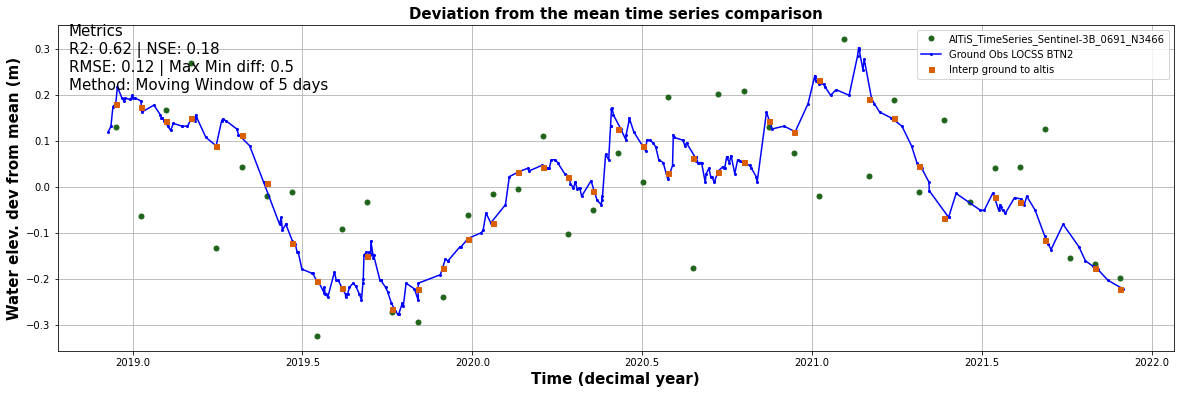

Station America/New_York ncolgeoid: GEOID_01_MEDIAN CFN2 ground_st: True df_altis: (61, 8)


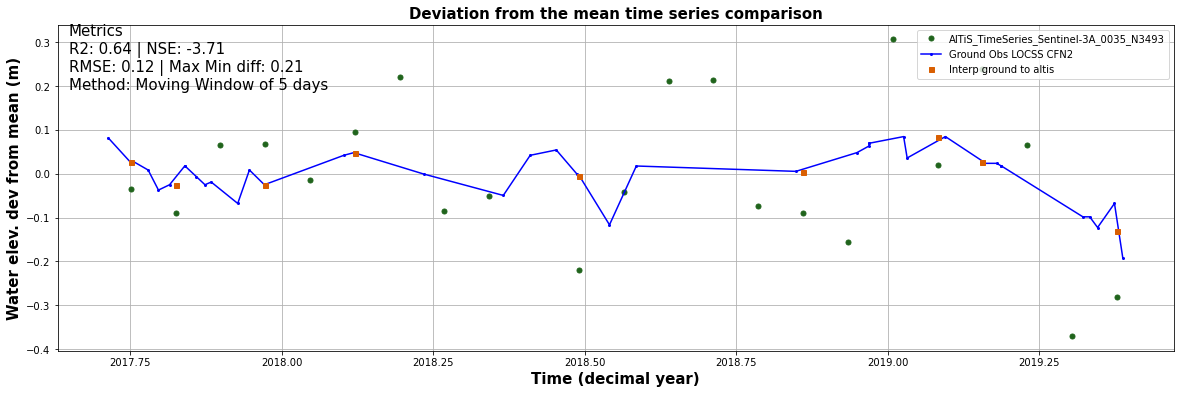

Station America/Edmonton ncolgeoid: GEOID_01_MEDIAN HMT2 ground_st: True df_altis: (73, 8)


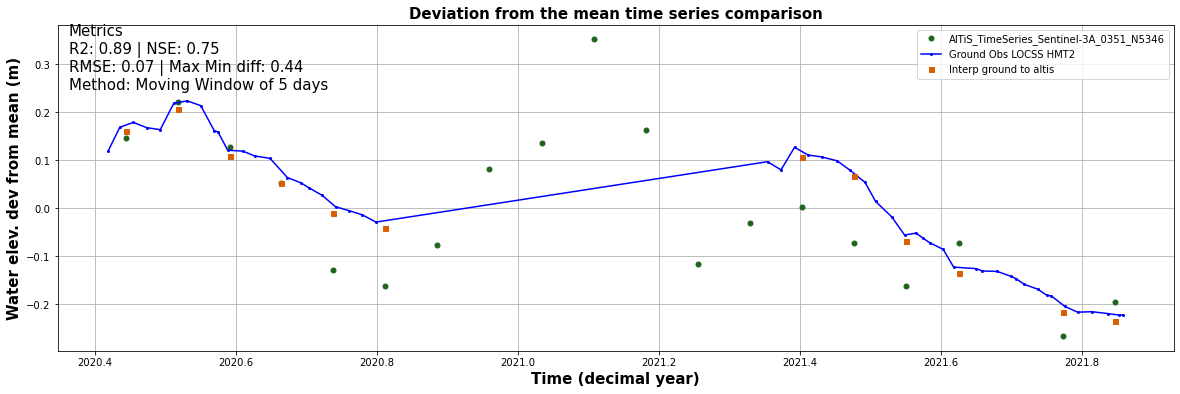

Station Asia/Dhaka ncolgeoid: GEOID_01_MEDIAN KHB2 ground_st: True df_altis: (67, 8)


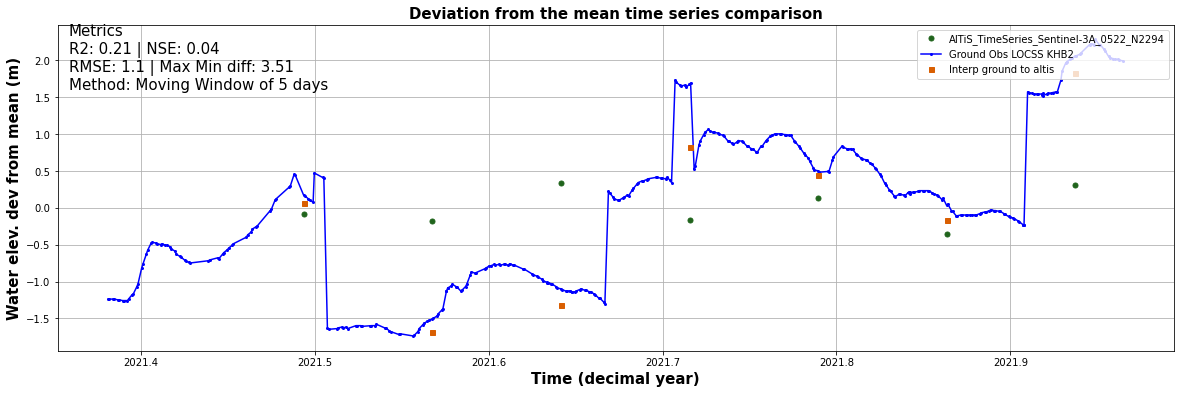

Station America/New_York ncolgeoid: GEOID_01_MEDIAN PHN2 ground_st: True df_altis: (78, 8)


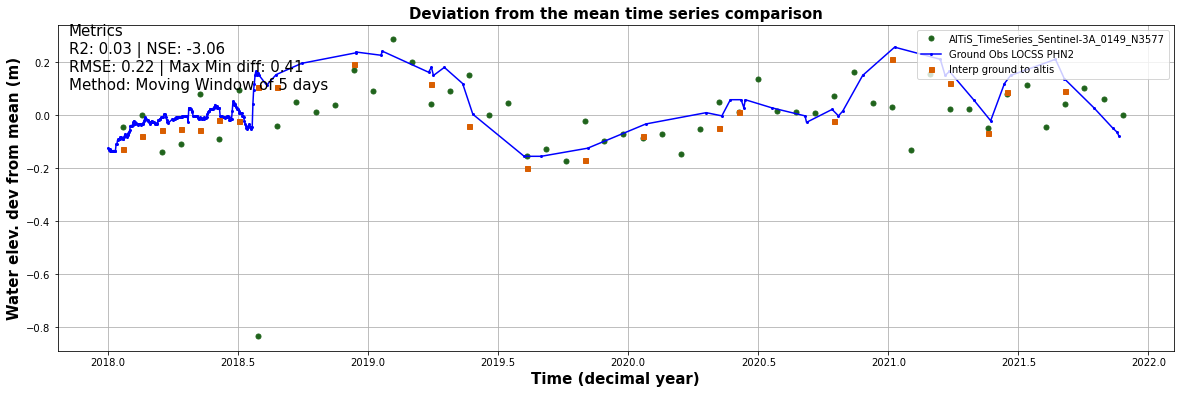

Station America/Chicago ncolgeoid: GEOID_01_MEDIAN QUL2 ground_st: True df_altis: (13, 8)


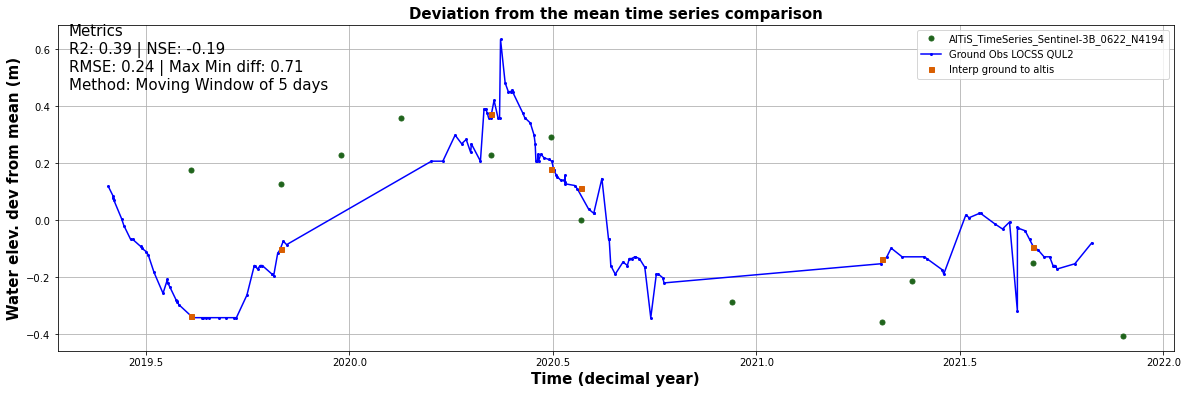

Station America/Los_Angeles ncolgeoid: GEOID_01_MEDIAN RAW2 ground_st: True df_altis: (22, 8)


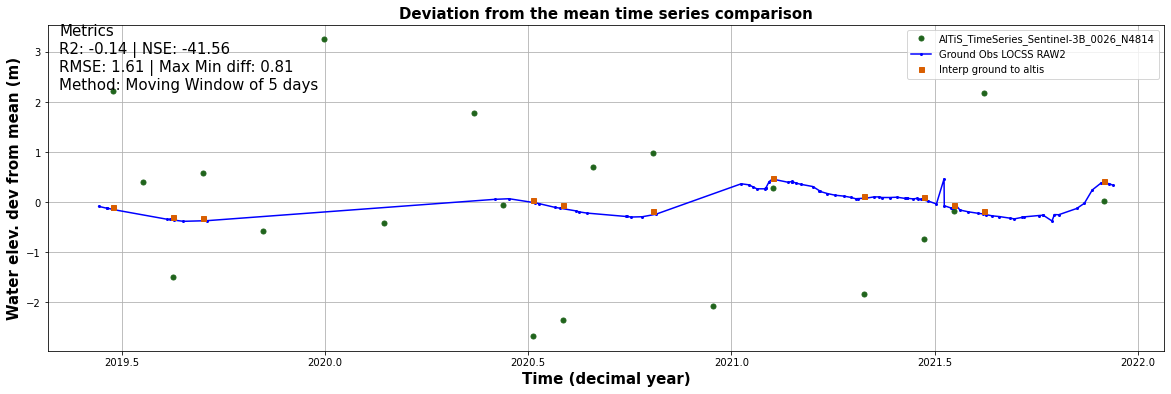

Station America/Los_Angeles ncolgeoid: GEOID_01_MEDIAN SAW2 ground_st: True df_altis: (75, 8)


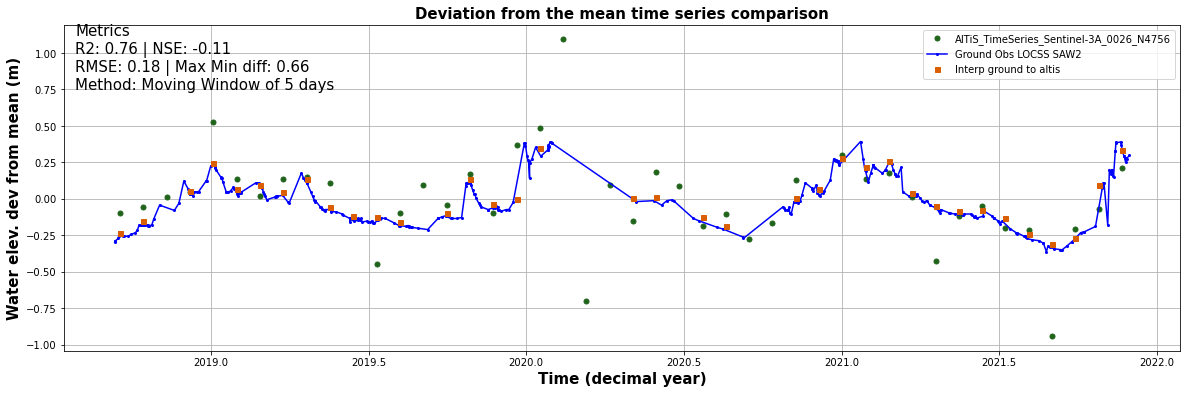

Station Antarctica/McMurdo ncolgeoid: GEOID_01_MEDIAN SLL2 ground_st: True df_altis: (34, 8)


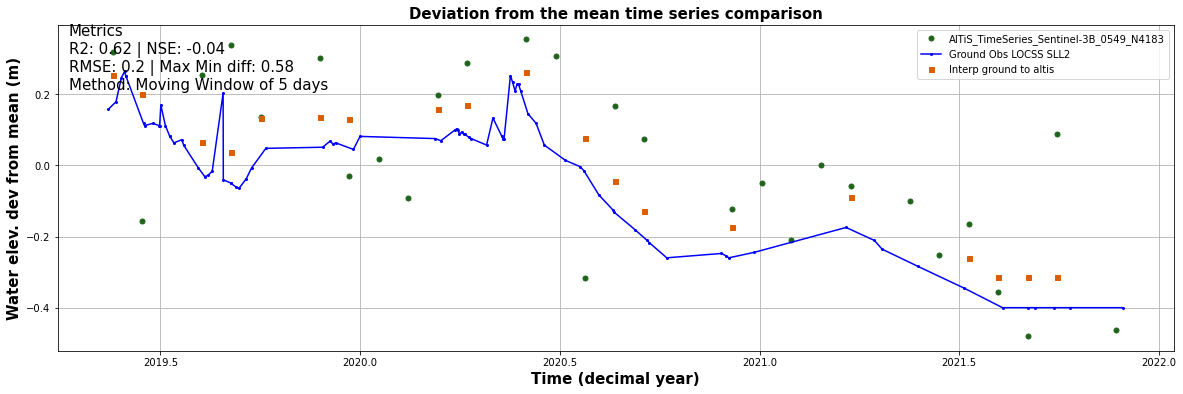

Station America/Los_Angeles ncolgeoid: GEOID_01_MEDIAN WEW2 ground_st: True df_altis: (76, 8)


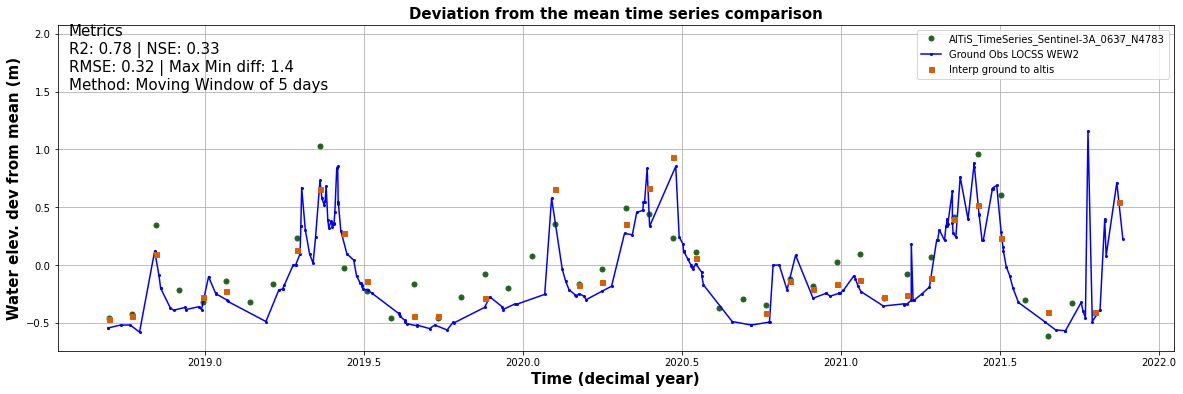

Station Antarctica/McMurdo ncolgeoid: GEOID_01_MEDIAN YSL2 ground_st: True df_altis: (26, 8)


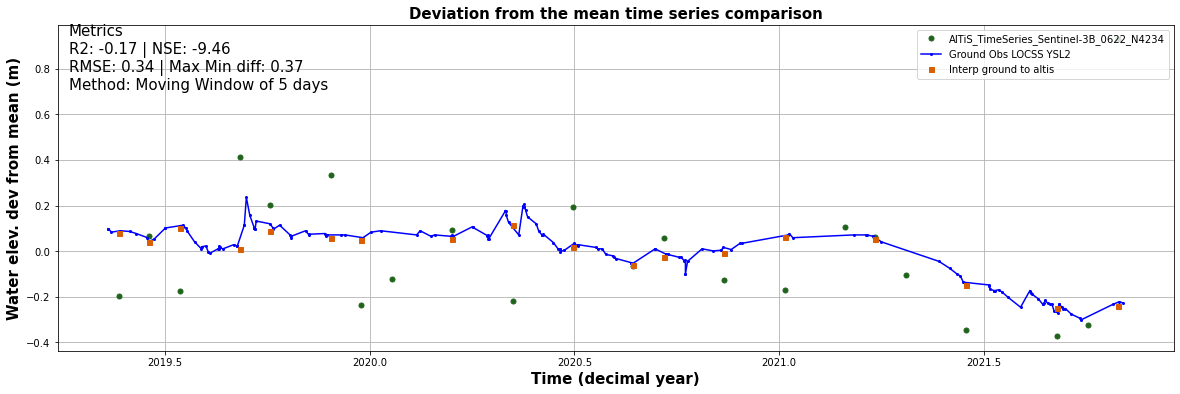

Station Asia/Dhaka ncolgeoid: GEOID_01_MEDIAN TAB2 ground_st: True df_altis: (76, 8)


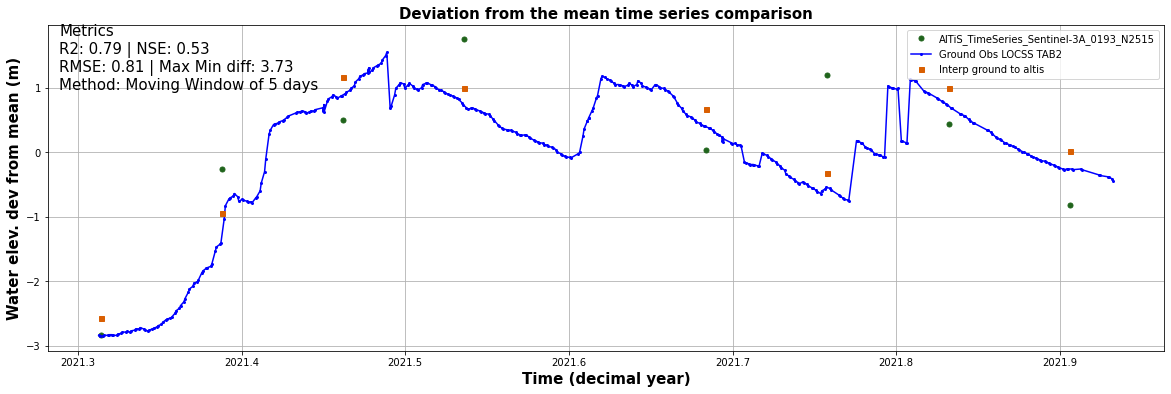

Station Asia/Dhaka ncolgeoid: GEOID_01_MEDIAN MAB2 ground_st: True df_altis: (76, 8)


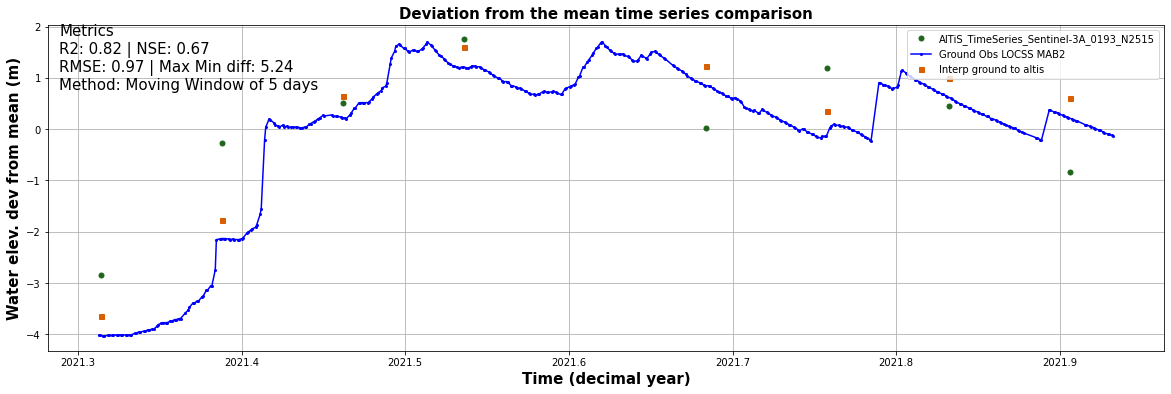

Station America/Sao_Paulo ncolgeoid: GEOID_01_MEDIAN 19060 ground_st: False df_altis: (52, 8)
Station America/Sao_Paulo ncolgeoid: GEOID_EIGEN6C4D_MEDIAN 19060 ground_st: False df_altis: (106, 8)
Station America/Maceio ncolgeoid: GEOID_01_MEDIAN 19126 ground_st: False df_altis: (37, 8)
Error: no column geoid_01_median in ../data/alti_timeseries/AlTiS_TimeSeries_Sentinel-3A_0190_S2751.csv
Station America/Sao_Paulo ncolgeoid: GEOID_01_MEDIAN 19069 ground_st: False df_altis: (56, 8)
Station America/Chicago ncolgeoid: GEOID_01_MEDIAN 2464800 ground_st: False df_altis: (78, 8)
Station America/Chicago ncolgeoid: GEOID_01_MEDIAN 6604000 ground_st: False df_altis: (41, 8)
Station America/Chicago ncolgeoid: GEOID_01_MEDIAN 6903880 ground_st: False df_altis: (77, 8)
Station Asia/Karachi ncolgeoid: GEOID_MEDIAN MRP2 ground_st: True df_altis: (219, 8)


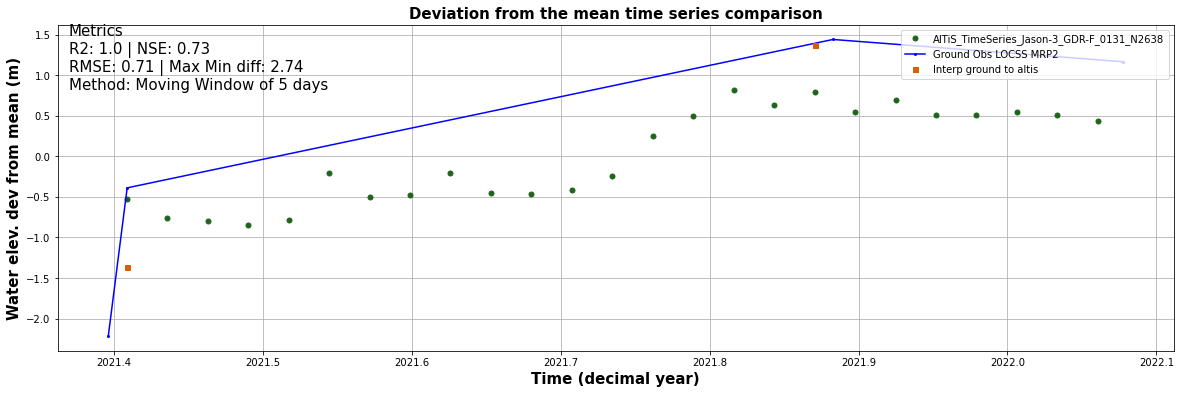

Station America/Fortaleza ncolgeoid: GEOID_MEDIAN 12036 ground_st: False df_altis: (94, 8)
Station America/Fortaleza ncolgeoid: GEOID_MEDIAN 12036 ground_st: False df_altis: (151, 8)
Station America/Fortaleza ncolgeoid: GEOID_01_MEDIAN 12030 ground_st: False df_altis: (79, 8)
Station America/Fortaleza ncolgeoid: GEOID_01_MEDIAN 12030 ground_st: False df_altis: (80, 8)
Station America/New_York ncolgeoid: GEOID_01_MEDIAN CQK2 ground_st: True df_altis: (40, 8)
Station America/New_York ncolgeoid: GEOID_01_MEDIAN CQK2 ground_st: True df_altis: (26, 8)
Station America/Edmonton ncolgeoid: GEOID_01_MEDIAN SKT2 ground_st: False df_altis: (44, 8)
Station America/Edmonton ncolgeoid: GEOID_01_MEDIAN SKT2 ground_st: False df_altis: (44, 8)
Station America/Edmonton ncolgeoid: GEOID_01_MEDIAN SKT2 ground_st: False df_altis: (20, 8)
Station America/Los_Angeles ncolgeoid: GEOID_01_MEDIAN MCW2 ground_st: True df_altis: (35, 8)


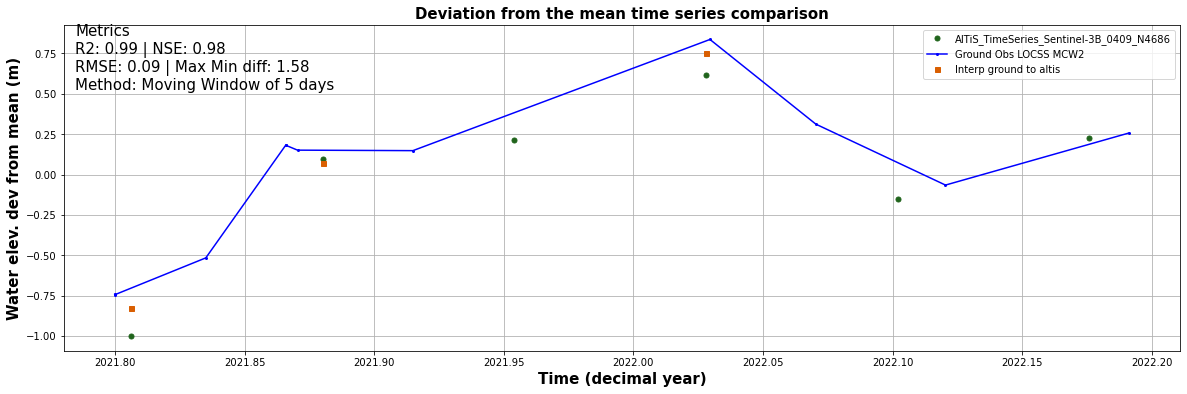

Station America/Los_Angeles ncolgeoid: GEOID_01_MEDIAN MCW2 ground_st: True df_altis: (39, 8)


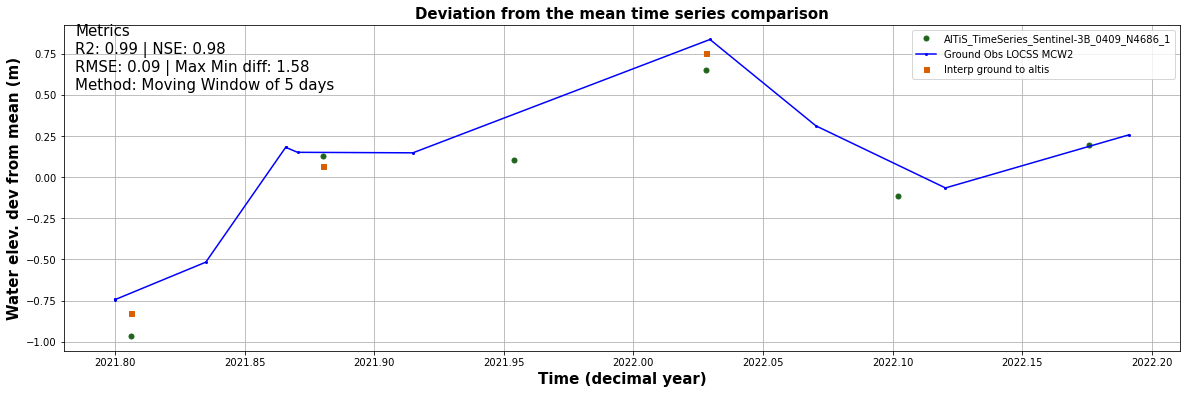

Station America/Los_Angeles ncolgeoid: GEOID_01_MEDIAN PAW2 ground_st: True df_altis: (37, 8)


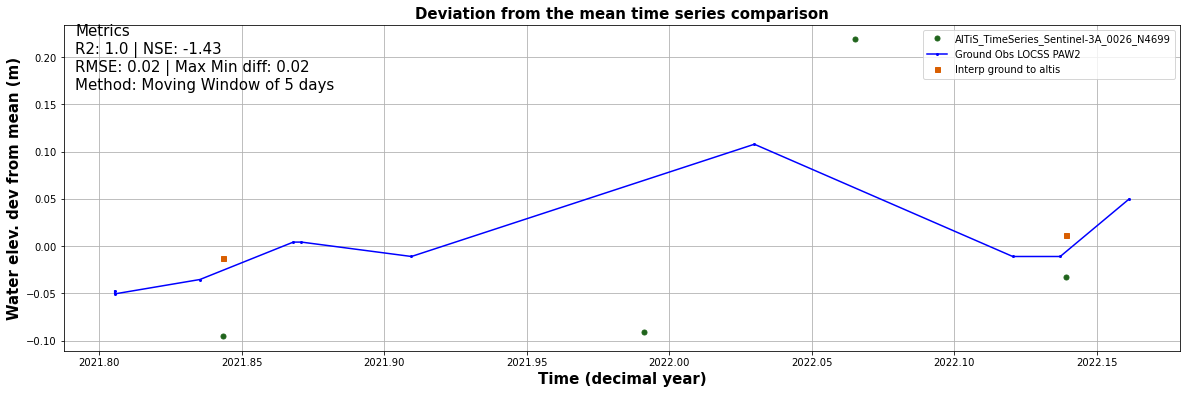

Station America/New_York ncolgeoid: GEOID_01_MEDIAN SPA2 ground_st: False df_altis: (34, 8)
Station America/Fortaleza ncolgeoid: GEOID_MEDIAN 12030 ground_st: False df_altis: (197, 8)
Station America/Fortaleza ncolgeoid: GEOID_MEDIAN 12030 ground_st: False df_altis: (211, 8)


In [38]:
# Accuracies with moving window

#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'

time_fig=datetime.now().strftime("%Y%m%d_%H_%M")
path_name='../data/results/plots_mv_'+time_fig+'/'

if save_plot:
    output_f=path_name
else:
    output_f=None

if start==0:
    df_final_altis=pd.DataFrame()
    df_final_ground=pd.DataFrame()
    df_cm=pd.DataFrame()
    

path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
lon_fd='lon'
lat_fd='lat'

altis_csv=pd.read_csv(path)
#Add the time_zone to each coordinate 
tf=TimezoneFinder()
altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
#filter only altis time series with ground observations
altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]


df_gts=df_ground_ts

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999

wse_ref='e'

i=1


for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    ncolgeoid=row['ncolgeoid']
    # Call every altis relative to the ellipsoide
    
    # is_Sentinel=altis_name.find('Sentinel-3')
    # if is_Sentinel!=-1:
    if ncolgeoid!='No':
        #Call the function with geoid field and wse_type='e'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd,
                                                        nodataalti,ncolgeoid=ncolgeoid,wse_ref=wse_ref)
    else:
        #Call the function with geoid field and wse_type='g'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
    print('Station '+row['tz']+' ncolgeoid: '+str(ncolgeoid).upper(), st_id+' ground_st: '+str(not df_ground_st.empty)+' df_altis: '+str(df_altis.shape))
    # print(df_altis.columns)
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        #Convert time in df_gts_st to UTC
        source=df_ground_st['source'].iloc[0]

        df_ground_st['date_utc']=[timezone(row['tz']).localize(date).astimezone(utc.zone) for date in df_ground_st[st_date_fd]]
        
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_st['altis_d_1']=altis_name

        if st_id=='CQK2':
            continue
        (df_altis_c, df_ground_c)=get_common_period(df_ts1=df_altis, df_ts2=df_ground_st, 
                                                    date_ts1_fd=altis_date_fd, date_ts2_fd='date_utc', delta_days=True, ndays=10)
        
        if source=='USGS':
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=False)
        else:
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_c=df_ground_c.sort_values(by=['decimal_y'])
        df_altis_c=df_altis_c.sort_values(by=['decimal_y'])
        # print(df_altis_c.head())
        delta=5
        median_fd='median_d_'+str(delta)
        mean_fd='mean_d_'+str(delta)
        std_fd='std_d_'+str(delta)
        count_fd='count_d_'+str(delta)

        df_altis_c[[median_fd,mean_fd, std_fd,count_fd]]=df_altis_c.apply(lambda x: moving_window_around_date(df_ground_c,
                                                                                                              x[altis_date_fd],
                                                                                                              delta,
                                                                                                              'height',
                                                                                                              'date_utc'), axis=1).apply(pd.Series)

        corr_alti_insi, ns_alti_insi, rmse_alti_insi, ampl_insi=get_comp_metrics(ts_obs=df_altis_c['height'].to_numpy(),ts_est=df_altis_c[median_fd].to_numpy())
        
        #Create a output dataframe with the metrics
        cm_dict={'station':[st_id], 'altis':[altis_name], 'source':[source], 'method':['Moving Window'],
                'r2':[corr_alti_insi],'NSF':[ns_alti_insi],'RMSE':[rmse_alti_insi],'APL':[ampl_insi]}
        df_cmi=pd.DataFrame(cm_dict)
        
        df_cm=pd.concat((df_cm,df_cmi), axis=0)
        df_final_altis=pd.concat((df_final_altis,df_altis_c), axis=0)
        df_final_ground=pd.concat((df_final_ground,df_ground_c), axis=0)
        
        error_m_text='\nR2: '+str(np.round(corr_alti_insi, decimals=2))+' | '+\
        'NSE: '+str(np.round(ns_alti_insi,decimals=2))+'\n'+\
        'RMSE: '+str(np.round(rmse_alti_insi,decimals=2))+' | '+\
        'Max Min diff: '+str(np.round(ampl_insi,decimals=2))+'\n'+\
        'Method: Moving Window of '+str(delta)+' days'

        labels=altis_name
        labelg='Ground Obs '+source+' '+st_id
        labeli='Interp ground to altis'

        

        dfs=df_altis_c
        dfg=df_ground_c
        # dic_intp={'decimal_y':df_altis_plot['decimal_y'].to_numpy(), 'height':inh_2_altidy}

        dfi=df_altis_c[['decimal_y',median_fd]].copy()#pd.DataFrame(dic_intp)
        dfi=dfi.rename(columns={median_fd:'height'})
        date_plot_fd='decimal_y'
        height_plot_fd='height'
        nfig=i
        if show_plot:
            p=plot_dev_mean(nfig,dfs, dfg, dfi, source, st_id, altis_name, date_plot_fd, height_plot_fd, labels, labelg, labeli, error_m_text, output_f)
            p.show()
            p.close()
    
        
        i=i+1
        
        
        
df_final_altis['method']='Moving Window'
df_final_ground['method']='Moving Window'
    


In [33]:
x,y=get_common_period(df_ts1=df_altis, df_ts2=df_ground_st, 
                                                    date_ts1_fd=altis_date_fd, date_ts2_fd='date_utc', delta_days=True, ndays=10)

In [36]:
df_ground_st.shape

(2, 20)

In [10]:
# #Do the linear interpolation to get the accuracies

#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'
time_fig=datetime.now().strftime("%Y%m%d_%H_%M")
path_name='../data/results/plots_it_'+time_fig+'/'

if save_plot:
    output_f=path_name
else:
    output_f=None

if start==0:
    df_final_altis=pd.DataFrame()
    df_final_ground=pd.DataFrame()
    df_cm=pd.DataFrame()

# #Read shapefile with all the coordinates and the id of the files

path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
lon_fd='lon'
lat_fd='lat'
# altis_shp
#altis_shp=gpd.read_file(path)
altis_csv=pd.read_csv(path)
#Add the time_zone to each coordinate 
tf=TimezoneFinder()
# altis_shp['tz']=[tf.timezone_at(lng=row[0], lat=row[1]) for row in altis_shp[[lon_fd, lat_fd]]]


# altis_shp['tz']=altis_shp.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)

#filter only altis time series with ground observations
# altis_w_gts_shp=altis_shp.loc[altis_shp['station_id'].notna()]
altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]


#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'
df_gts=df_ground_ts

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999

wse_ref='e'
ncolgeoid='geoid_01_median' #PENDING RAISE AND HANDLE THE EXCEPTION WHEN geoid column not found

    
i=1

for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    ncolgeoid=row['ncolgeoid']
    # Call every altis relative to the ellipsoide
    
    # is_Sentinel=altis_name.find('Sentinel-3')
    # if is_Sentinel!=-1:
    if ncolgeoid!='No':
        #Call the function with geoid field and wse_type='e'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd,
                                                        nodataalti,ncolgeoid=ncolgeoid,wse_ref=wse_ref)
    else:
        #Call the function with geoid field and wse_type='g'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
    print('Station '+row['tz']+' ncolgeoid: '+str(ncolgeoid).upper(), st_id+' ground_st: '+str(not df_ground_st.empty)+
          ' df_altis: '+str(df_altis.shape)+' df_ground_st: '+str(df_ground_st.shape))
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        #Convert time in df_gts_st to UTC
        source=df_ground_st['source'].iloc[0]
        #if source !='RVBR':
        #     continue
            
       # df_ground_st['date_utc']=df_ground_st[st_date_fd].dt.tz_localize(row['tz']).dt.tz_convert('utc')
        df_ground_st['date_utc']=[timezone(row['tz']).localize(date).astimezone(utc.zone) for date in df_ground_st[st_date_fd]]
        # Cut the time series to the same period the time series
        (df_altis_c, df_ground_c)=get_common_period(df_ts1=df_altis, df_ts2=df_ground_st, 
                                             date_ts1_fd=altis_date_fd, date_ts2_fd='date_utc', delta_days=False, ndays=0)
       
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        #Recalculate date with dates in utc
        if source=='USGS':
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=False)
        else:
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_c=df_ground_c.sort_values(by=['decimal_y'])
        df_altis_c=df_altis_c.sort_values(by=['decimal_y'])
        
        df_ground_c['altis_d_1']=altis_name


        (inh_2_altidy, corr_alti_insi, ns_alti_insi, rmse_alti_insi,
         ampl_insi) = interp_ts12ts2_stat(df_ground_c['decimal_y'].to_numpy(), df_ground_c['height'].to_numpy(), 
                                          df_altis_c['decimal_y'].to_numpy(), df_altis_c['height'].to_numpy())
        
        
                #Create a output dataframe with the metrics
        cm_dict={'station':[st_id], 'altis':[altis_name], 'source':[source], 'method':['Linear Interpolation'],
                'r2':[corr_alti_insi],'NSF':[ns_alti_insi],'RMSE':[rmse_alti_insi],'APL':[ampl_insi]}
        df_cmi=pd.DataFrame(cm_dict)
        
        #Concat to final dataframes 
        df_final_altis=pd.concat((df_final_altis, df_altis_c), axis=0)
        df_final_ground=pd.concat((df_final_ground, df_ground_c), axis=0)
        
        df_cm=pd.concat((df_cm,df_cmi), axis=0)
        
        error_m_text='\nR2: '+str(np.round(corr_alti_insi, decimals=2))+' | '+\
        'NSE: '+str(np.round(ns_alti_insi,decimals=2))+'\n'+\
        'RMSE: '+str(np.round(rmse_alti_insi,decimals=2))+' | '+\
        'Max Min diff: '+str(np.round(ampl_insi,decimals=2))+'\n'+\
        'Method: Linear interpolation'
        
        
        labels=altis_name
        labelg='Ground Obs '+source+' '+st_id
        labeli='Interp ground to altis'


        dfs=df_altis_c
        dfg=df_ground_c
        print('dimension ground altis', str(dfg.shape)+' '+str(dfs.shape))
        dic_intp={'decimal_y':df_altis_c['decimal_y'].to_numpy(), 'height':inh_2_altidy}

        dfi=pd.DataFrame(dic_intp)
        date_plot_fd='decimal_y'
        height_plot_fd='height'
        nfig=i
        if show_plot:
            p=plot_dev_mean(nfig,dfs, dfg, dfi, source, st_id, altis_name, date_plot_fd, height_plot_fd, labels, labelg, labeli, error_m_text, output_f)
            p.show()
            p.close()

        i=i+1
        
        
df_final_altis['method']='Linear interp'    
df_final_ground['method']='Linear interp'    



Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN 1824 ground_st: True df_altis: (73, 8) df_ground_st: (8037, 9)
dimension ground altis (1998, 11) (73, 9)
Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN 2028 ground_st: True df_altis: (77, 8) df_ground_st: (31001, 9)
dimension ground altis (1925, 11) (72, 9)
Station America/Argentina/Salta ncolgeoid: GEOID_EIGEN6C4D_MEDIAN 2028 ground_st: True df_altis: (104, 8) df_ground_st: (31001, 9)
dimension ground altis (1082, 11) (104, 9)
Station America/Argentina/Salta ncolgeoid: GEOID_MEDIAN 2028 ground_st: True df_altis: (157, 8) df_ground_st: (31001, 9)
dimension ground altis (1399, 11) (138, 9)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN 2234 ground_st: True df_altis: (76, 8) df_ground_st: (26584, 9)
dimension ground altis (2003, 11) (73, 9)
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN 2234 ground_st: True df_altis: (75, 8) df_ground_st: (26584, 9)
dimension ground altis (1974, 11) (72

In [11]:
#Save comparison metrics 
df_cm['r2']=[np.round(v, decimals=3) for v in df_cm['r2']]
df_cm['NSF']=[np.round(v, decimals=3) for v in df_cm['NSF']]
df_cm['RMSE']=[np.round(v, decimals=3) for v in df_cm['RMSE']]
df_cm['APL']=[np.round(v, decimals=3) for v in df_cm['APL']]
     
df_cm.to_csv('../data/results/comparison_'+time_fig+'.csv', sep=',')


In [9]:
df=pd.read_csv('../data/results/comparison_20220412_18_40.csv', sep=',')
df_t

,station,altis,source,method,variable,value
0,1824,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,ARHN,Moving Window,r2,0.939
1,2028,AlTiS_TimeSeries_Sentinel-3A_0749_S4016,ARHN,Moving Window,r2,0.973
2,2028,AlTiS_TimeSeries_Jason-3_0215_S4017,ARHN,Moving Window,r2,0.886
3,2028,AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017,ARHN,Moving Window,r2,0.906
4,2234,AlTiS_TimeSeries_Sentinel-3A_0635_S4324,ARHN,Moving Window,r2,0.652
...,...,...,...,...,...,...
211,19126,AlTiS_TimeSeries_Sentinel-3A_0560_S0953,RVBR,Linear Interpolation,APL,0.464
212,19069,AlTiS_TimeSeries_Sentinel-3A_0190_S2751,RVBR,Linear Interpolation,APL,17.556
213,2464800,AlTiS_TimeSeries_Sentinel-3A_0194_N3338,USGS,Linear Interpolation,APL,1.489
214,6604000,AlTiS_TimeSeries_Sentinel-3B_0480_N4348,USGS,Linear Interpolation,APL,1.033


In [6]:
#Plot methods comparison metrics
import seaborn as sns
import matplotlib as plt
import pandas as pd

sns.set_style('white')
sns.set_context('notebook')#, font_scale=1.5)

# df=df_cm.copy()
df=pd.read_csv('../data/results/comparison_20220412_18_40.csv', sep=',')

df_t=pd.melt(df, id_vars=['station', 'altis', 'source', 'method','area_skm'], value_vars=['r2','NSF','RMSE','APL'], ignore_index=True)
df_t['mission']=[x.split('_')[2] for x in df_t['altis']]
# df_t['to_plot_m']=[x.split('_')[2] for x in df_t['mission'] if x]
df_t.loc[df_t['mission'].isin(['Sentinel-3B','Jason-3']),'to_plot_m']=1
df_t.loc[~df_t['mission'].isin(['Sentinel-3B','Jason-3']),'to_plot_m']=0
df_t=df_t.loc[df_t['area_skm'].notna()]
# df['st_alti']
df_t.head()

,station,altis,source,method,area_skm,variable,value,mission,to_plot_m
0,1824,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,ARHN,Moving Window,36.62,r2,0.939,Sentinel-3A,0.0
1,2028,AlTiS_TimeSeries_Sentinel-3A_0749_S4016,ARHN,Moving Window,50.67,r2,0.973,Sentinel-3A,0.0
3,2028,AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017,ARHN,Moving Window,50.67,r2,0.906,Jason-3,1.0
4,2234,AlTiS_TimeSeries_Sentinel-3A_0635_S4324,ARHN,Moving Window,8.90,r2,0.652,Sentinel-3A,0.0
5,2234,AlTiS_TimeSeries_Sentinel-3A_0676_S4325,ARHN,Moving Window,8.90,r2,0.560,Sentinel-3A,0.0


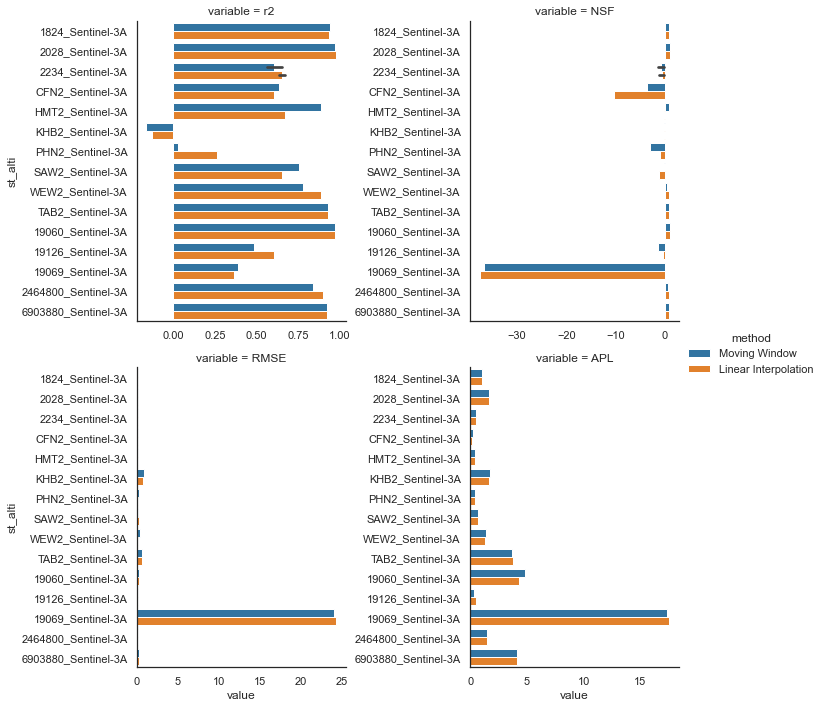

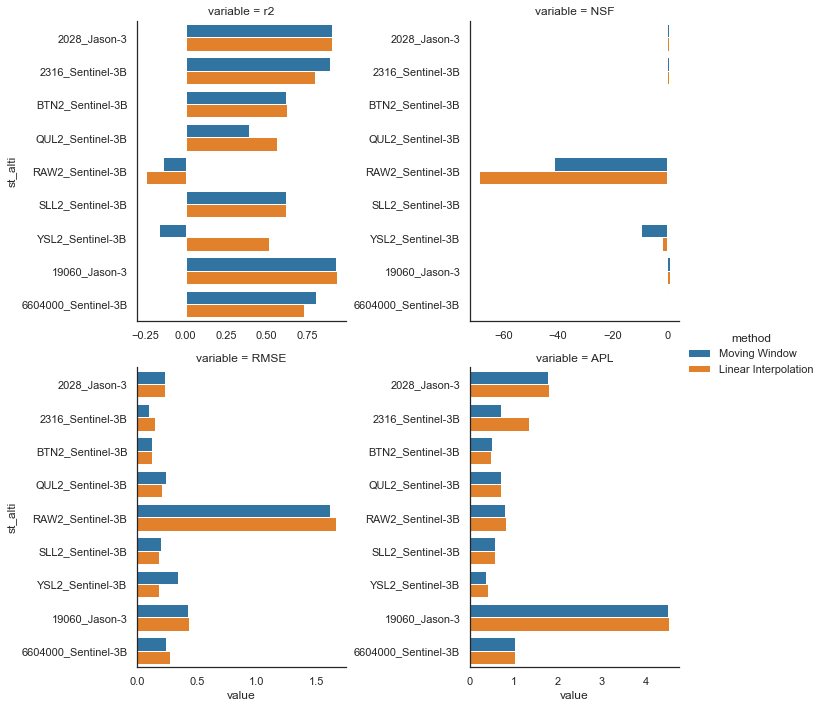

In [7]:
for s in df_t['to_plot_m'].unique():
    df=df_t.loc[df_t['to_plot_m']==s].copy()
    df['st_alti']=df.apply(lambda x:str(x['station'])+'_'+x['mission'], axis=1) #LO QUE NECESITA ES ESTO
    x_fd='value'
    y_fd='st_alti'
    hue='method'
    col='variable'
    row='variable'#'source'
    g = sns.catplot(data=df,sharex=False,sharey=False,
                x=x_fd, y=y_fd,
                hue=hue, #col=col,
                col=row, col_wrap=2,
                kind="bar",
                dodge=True)
    #                height=4, aspect=.7)
    g
    del df

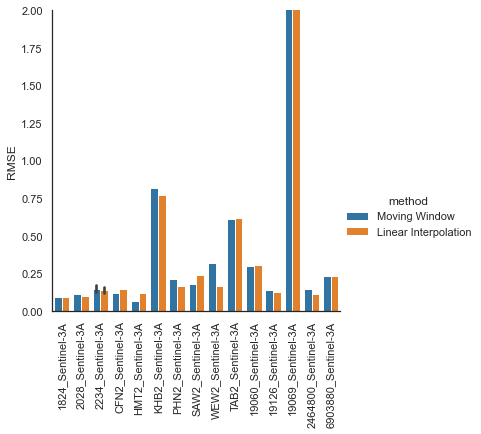

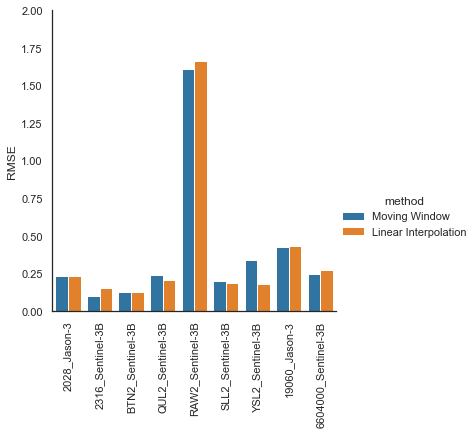

In [15]:
for s in df_t['to_plot_m'].unique():
    df=df_t.loc[df_t['to_plot_m']==s].copy()
    df['st_alti']=df.apply(lambda x:str(x['station'])+'_'+x['mission'], axis=1) #LO QUE NECESITA ES ESTO
    df=df.loc[df['variable']=='RMSE']
    x_fd='st_alti'
    y_fd='value'
    hue='method'
    #col='variable'
    #row='variable'#'source'
    g = sns.catplot(data=df,sharex=False,sharey=False,
                x=x_fd, y=y_fd,
                hue=hue, #col=col,
     #           col=row, col_wrap=2,
                kind="bar",
                dodge=True)
    #                height=4, aspect=.7)
    g
    g.set_xticklabels(rotation=90)
    g.set_axis_labels(x_var='',y_var='RMSE')
    g.set(ylim=(0,2))
    del df

  station                                      altis source         method  \
0    1824    AlTiS_TimeSeries_Sentinel-3A_0562_S4128   ARHN  Moving Window   
1    2028    AlTiS_TimeSeries_Sentinel-3A_0749_S4016   ARHN  Moving Window   
3    2028  AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017   ARHN  Moving Window   
4    2234    AlTiS_TimeSeries_Sentinel-3A_0635_S4324   ARHN  Moving Window   
5    2234    AlTiS_TimeSeries_Sentinel-3A_0676_S4325   ARHN  Moving Window   

   area_skm variable  value      mission           st_alti  
0     36.62       r2  0.939  Sentinel-3A  1824_Sentinel-3A  
1     50.67       r2  0.973  Sentinel-3A  2028_Sentinel-3A  
3     50.67       r2  0.906      Jason-3      2028_Jason-3  
4      8.90       r2  0.652  Sentinel-3A  2234_Sentinel-3A  
5      8.90       r2  0.560  Sentinel-3A  2234_Sentinel-3A  


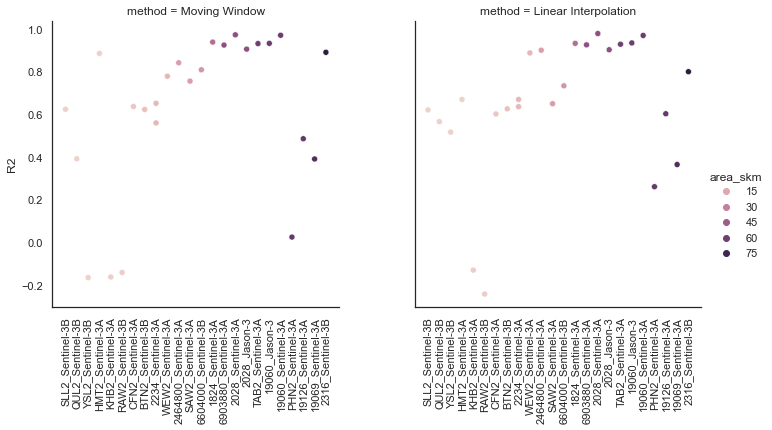

In [3]:
df=df_t.copy()
df['st_alti']=df.apply(lambda x:str(x['station'])+'_'+x['mission'], axis=1) #LO QUE NECESITA ES ESTO
# df=df.loc[df['variable'].isin(['r2', 'RMSE'])]
df=df.loc[df['variable']=='r2']
# sns.set(rc = {'figure.figsize':(10,2)})
sns.set_style('white')

print(df.head())
df=df.sort_values(by=['area_skm'])
x_fd='st_alti'
y_fd='value'
hue='area_skm'#'method'
col='variable'
row='method'#'source'
# for i in ['r2', 'RMSE']:
# df=df.loc[df[col]==i]
g = sns.relplot(data=df,#sharex=False,sharey=False,
        x=x_fd, y=y_fd,
        hue=hue, col=row,
        #col=row,# col_wrap=2,
        kind="scatter")#,
            #join=False)#,
        #dodge=True)
#                height=4, aspect=.7)
g
g.set_xticklabels(rotation=90)
g.set_axis_labels(x_var='', y_var='R2')
# g.set(ylim=(0,2))
del df
# g = sns.catplot(data=df,sharex=False,sharey=False,
#             x=x_fd, y=y_fd,
#             hue=hue, #row=row,
#  #           col=row, col_wrap=2,
#             kind="point",
#                 join=False)#,
#             #dodge=True)
# #                height=4, aspect=.7)
# g
# g.set_xticklabels(rotation=90)
# del df

In [ ]:
for s in df_t['source'].unique():
    df=df_t.loc[df_t['source']==s].copy()
    df['st_alti']=df.apply(lambda x:str(x['station'])+'_'+x['altis'][17:], axis=1) #LO QUE NECESITA ES ESTO
    x_fd='value'
    y_fd='st_alti'
    hue='method'
    col='variable'
    row='variable'#'source'
    g = sns.catplot(data=df,sharex=False,sharey=False,
                x=x_fd, y=y_fd,
                hue=hue, #col=col,
                col=row, col_wrap=2,
                kind="bar",
                dodge=True)
    #                height=4, aspect=.7)
    g
    del df

In [ ]:
# #read all altiss 


# import geoplot as gplt
# #WRITE AS FUNCTIONS TO MOVE LATER
# #Read shapefile with all the coordinates and the id of the files
#path= '/home/angelica/Dropbox/Research/LOCSS/Denis_Sylvain/15_L_Altis_20220318/lonlat_vs_altis_ed.shp' When it is a shape file
path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
lon_fd='lon'
lat_fd='lat'
# altis_shp
#altis_shp=gpd.read_file(path)
altis_csv=pd.read_csv(path)
#Add the time_zone to each coordinate 
tf=TimezoneFinder()
# altis_shp['tz']=[tf.timezone_at(lng=row[0], lat=row[1]) for row in altis_shp[[lon_fd, lat_fd]]]


# altis_shp['tz']=altis_shp.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)

#filter only altis time series with ground observations
# altis_w_gts_shp=altis_shp.loc[altis_shp['station_id'].notna()]
altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]
# print(altis_shp.shape)
# print(altis_w_gts_shp.shape)
# print(altis_w_gts_shp.columns)
# print(altis_csv.shape)
# print(altis_w_gts_csv.shape)
# print(altis_w_gts_csv.columns)

#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'
df_gts=df_ground_ts

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999
i=1
df_final_altis=pd.DataFrame()
df_final_ground=pd.DataFrame()

for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    
    df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        source=df_ground_st['source'].iloc[0]
        if source=='RVBR':
            continue
        #Convert time in df_gts_st to UTC
        
        df_ground_st['date_utc']=df_ground_st[st_date_fd].dt.tz_localize(row['tz']).dt.tz_convert('utc')
        #print(df_ground_st.head(), st_id)
        
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        if source=='USGS':
            df_ground_st=get_date_time_cols(df_ground_st, st_date_fd, has_hour=False)
        else:
            df_ground_st=get_date_time_cols(df_ground_st, st_date_fd, has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_st=df_ground_st.sort_values(by=['decimal_y'])
        df_ground_st['altis_d_1']=altis_name

        #Concat to final dataframes 
        df_final_altis=pd.concat((df_final_altis, df_altis), axis=0)
        df_final_ground=pd.concat((df_final_ground, df_ground_st), axis=0)

        #Get the max and mins
        altis_min=df_altis['decimal_y'].min()
        ground_min=df_ground_st['decimal_y'].min()
        altis_max=df_altis['decimal_y'].max()
        ground_max=df_ground_st['decimal_y'].max()
        # print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        # print('\nAltis_max Ground_max: ',[altis_max, ground_max])
        #print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        if altis_min>ground_min:
            df_ground_plot=df_ground_st.loc[(df_ground_st['decimal_y']>=altis_min)]#&(df_ground_st['decimal_y']<altis_max)]
            df_altis_plot=df_altis
        else:
            df_ground_plot=df_ground_st
            df_altis_plot=df_altis.loc[(df_altis['decimal_y']>=ground_min)]#&(df_ground_st['decimal_y']<altis_max)]


        (inh_2_altidy, corr_alti_insi, ns_alti_insi, rmse_alti_insi,
         ampl_insi) = interp_ts12ts2_stat(df_ground_plot['decimal_y'].to_numpy(), df_ground_plot['height'].to_numpy(), 
                                          df_altis_plot['decimal_y'].to_numpy(), df_altis_plot['height'].to_numpy())

        error_m_text='\nR2: '+str(np.round(corr_alti_insi, decimals=2))+' | '+\
        'NSE: '+str(np.round(ns_alti_insi,decimals=2))+'\n'+\
        'RMSE: '+str(np.round(rmse_alti_insi,decimals=2))+' | '+\
        'Max Min diff: '+str(np.round(ampl_insi,decimals=2))+'\n'



        plt.figure(i, figsize=(20, 6))
        gplot=plt.plot(df_ground_plot['decimal_y'], 
                       df_ground_plot['height'], '-go', markersize=1.5, label='Ground Obs '+st_id)
        iplot=plt.plot(df_altis_plot['decimal_y'].to_numpy(), 
                        inh_2_altidy, '--ks', markersize=3, label='Interp ground to altis')
        #plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
        plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
        plt.xlabel('Time (decimal year)', size=15, weight='bold')
        plt.ylabel('Water elevation (m)', size=15, weight='bold')
        plt.grid('on')
        plt.legend()
        plt.title('Water elevation (m)', size=15,
                  weight='bold')
        plt.savefig('../data/plots/'+source+'_ground_interp_'+st_id+'_vs_'+altis_name+'.png',
                     bbox_inches='tight')
        i=i+1
        
        
    
    #['gauge_id','source'
    
# def open_match__plot_station_altis(g_path,altis_name, st_id, df_gts, altis_date_fd, altis_height_fd, nodataalti=-9999):


In [134]:
df_altis_plot

,decimal_y,height,year,month,day,hour,name_altis,ground_st_1
0,2016.183479,275.212348,2016,3,8,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
1,2016.257250,275.298792,2016,4,4,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
2,2016.331020,275.150594,2016,5,1,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
3,2016.404791,275.351242,2016,5,28,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
4,2016.478561,275.598305,2016,6,24,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
...,...,...,...,...,...,...,...,...
72,2021.578505,275.578580,2021,7,31,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
73,2021.652477,274.932534,2021,8,27,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
74,2021.726450,274.997760,2021,9,23,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880
75,2021.800422,274.833224,2021,10,20,3,AlTiS_TimeSeries_Sentinel-3A_0635_N4086,6903880


In [48]:
df1=go.read_ground_data('LOCSS', station_id=lc_lakes)
# df.shape
# df_locss_filtered=df.loc[df['gauge_id'].isin(lc_lakes)]
# df_locss_filtered.shape
x=df1['gauge_id'].unique()
for a in x:
    print(df1.loc[df1['gauge_id']==a].shape)

(536, 24)
(53, 24)
(170, 24)
(256, 24)
(109, 24)
(393, 24)


In [13]:
df_arhn.head(3)

,date,height,source,gauge_id,year,month,day,hour,decimal_y
0,2010-03-01 12:00:00,2.30,ARHN,2830,2010,3,1,12,2010.163014
1,2010-03-02 12:00:00,2.30,ARHN,2830,2010,3,2,12,2010.165753
2,2010-03-03 13:00:00,2.31,ARHN,2830,2010,3,3,12,2010.168493


In [14]:
df_usgs.head(3)

,Unnamed: 0,agency_cd,gauge_id,date,height,X_00065_00003_cd,source,year,month,day,hour,decimal_y
0,1,USGS,2464800,2002-07-04,223.73,A,USGS,2002,7,4,12,2002.505479
1,2,USGS,2464800,2002-07-05,223.66,A,USGS,2002,7,5,12,2002.508219
2,3,USGS,2464800,2002-07-06,223.61,A,USGS,2002,7,6,12,2002.510959
